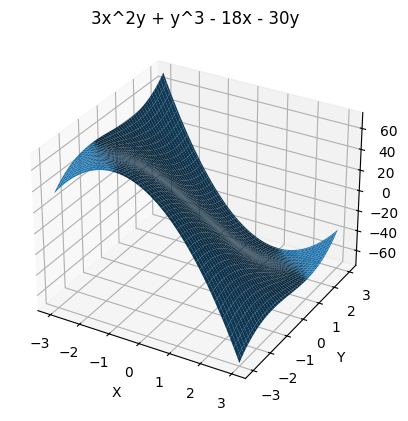

In [7]:
from playwright.sync_api import sync_playwright
from PyPDF2 import PdfMerger

import os
import re
import sys
import time
import shutil

ZOOM = 0.625

book_url = sys.argv[1]

# create cache dir
book_filename = book_url.split('/')[5]
cache_dir = f'{os.getcwd()}/{book_filename}'
try:
	os.mkdir(cache_dir)
except FileExistsError:
	pass

with sync_playwright() as playwright:
	browser = playwright.chromium.launch(headless=False)
	context = browser.new_context(storage_state="session.json" if 'session.json' in os.listdir('.') else None)

	page = context.new_page()
	page.goto('https://www.scribd.com/login', wait_until='domcontentloaded')

	page.locator("div.user_row").wait_for(state='attached', timeout=0)

	print('Logged in successfully.')

	storage = context.storage_state(path="session.json")
	context.close()
	browser.close()

	browser = playwright.chromium.launch(headless=True)

	print('Loading viewer...')

	context = browser.new_context(
		storage_state=  "session.json",
		viewport={'width': 1200, 'height': 1600},
		ignore_https_errors = True,
		user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.181 Safari/537.36'
	)
	context.set_extra_http_headers({'Accept-Language': 'en-US,en;q=0.9'})

	page = context.new_page()
	page.goto(book_url.replace('book', 'read'))

	if 'Browser limit exceeded' in page.content():
		context.close()
		browser.close()
		sys.exit('You have tried to read this from too many computers or web browsers recently, and will need to wait up to 24 hours before returning to this book.')

	# retrieve fonts
	font_style = page.locator('#fontfaces').inner_html()

	# open display menu
	page.locator('.icon-ic_displaysettings').wait_for(state='visible')
	page.evaluate("() => document.querySelector('.icon-ic_displaysettings').click()")

	# change to vertical mode
	page.locator('.vertical_mode_btn').wait_for(state='visible')
	page.evaluate("() => document.querySelector('.vertical_mode_btn').click()")

	# open toc menu
	page.locator('div.vertical_page[data-page="0"]').wait_for(state='visible')
	page.evaluate("() => document.querySelector('.icon-ic_toc_list').click()")
	chapter_selector = page.locator('li.text_btn[role="none"]')
	chapter_selector.nth(0).wait_for(state='visible')

	# retrieve the number of chapters
	num_of_chapters = chapter_selector.count()

	# load the first chapter
	page.evaluate("() => document.querySelector('li.text_btn[data-idx=\"0\"]').click()")
	chapter_no = 1

	# to render the chapter pages and save them as pdf
	render_page = context.new_page()
	render_page.set_viewport_size({"width": 1200, "height": 1600})

	while True:

		page.locator('div.vertical_page[data-page="0"]').wait_for()

		chapter_pages = page.locator('div.vertical_page')
		number_of_chapter_pages = chapter_pages.count()

		print(f'Downloading chapter {chapter_no}/{num_of_chapters} ({number_of_chapter_pages} pages)')

		merger = PdfMerger()

		page_no = 1

		while True:

			page_elem = chapter_pages.nth(page_no-1)
			html = page_elem.inner_html()

			# replace img urls
			html = html.replace('src="/', 'src="https://www.scribd.com/')

			# set page size
			match = re.findall('width: ([0-9.]+)px; height: ([0-9.]+)px;', html)[0]
			width, height = float(match[0]), float(match[1])
			style = f'@page {{ size: {width*ZOOM}px {height*ZOOM}px; margin: 0; }} @media print {{ html, body {{ height: {height*ZOOM}px; width: {width*ZOOM}px;}}}}'
			html = re.sub('data-colindex="0" style="', 'data-colindex="0" x="', html)
			html = re.sub('position: absolute.*?"', f'overflow: hidden; height: {height}px; width: {width}px; white-space: nowrap; zoom: {ZOOM};"', html)

			# render page
			content = f'<style>{style}{font_style}</style>{html}'
			render_page.set_content(content)

			# print pdf
			pdf_file = f'{cache_dir}/{chapter_no}_{page_no}.pdf'
			render_page.pdf(path=pdf_file, prefer_css_page_size = True)
			merger.append(pdf_file)

			if page_no == number_of_chapter_pages:
				merger.write(f"{cache_dir}/{chapter_no}.pdf")
				merger.close()
				break

			page_no += 1

		if chapter_no == num_of_chapters:
			break

		page.evaluate("() => document.querySelectorAll('button.load_next_btn')[0].click()")

		time.sleep(1)
		chapter_no += 1

print('Merging PDF pages...')
merger = PdfMerger()

for chapter_no in range(1, num_of_chapters+1):
	merger.append(f"{cache_dir}/{chapter_no}.pdf")

merger.write(f"{book_filename}.pdf")
merger.close()

# delete cache dir
shutil.rmtree(cache_dir)

print('Download completed, enjoy your book!')